# GDP Analysis: Machine Learning

In [1]:
# Import Dependencies
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import sqlalchemy
from config import pgadmin_password
from sqlalchemy import create_engine
import psycopg2
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


## Data Selection

### Connecting to PostgreSQL

In [2]:
# Import Postgres username, password, and database name
from sqlalchemy import create_engine

postgres_address = 'localhost'
postgres_port = '5432' 
postgres_username = 'postgres'
postgres_password = pgadmin_password
postgres_dbname = 'GDP_economics'
# A long string that contains the necessary Postgres login information
postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=postgres_username,
                        password=postgres_password,
                        ipaddress=postgres_address,
                        port=postgres_port,
                        dbname=postgres_dbname))
# Create the connection
cnx = create_engine(postgres_str)

### Loading Dataset

In [3]:
# Creating df for summary_gdp SQL table
summary_gdp_df= pd.read_sql_query('''SELECT * FROM summary_gdp;''', cnx)
summary_gdp_df.head()

,country_code,economy,region,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,...,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change,coft_id
0,AFG,Afghanistan,South Asia,2008,0.072075,0.103354,0.170865,0.000000,0.331855,0.242233,...,18.823282,31.094856,58.485536,22.258151,8.488684,3.577535,15.947558,54.600186,14.723942,1
1,AFG,Afghanistan,South Asia,2009,0.071051,0.079601,0.165315,0.000000,0.401368,0.308691,...,19.255622,32.643189,58.328269,23.138830,8.760733,3.879257,15.463749,53.510755,15.254662,2
2,AFG,Afghanistan,South Asia,2010,0.096194,0.078095,0.156798,0.000000,0.435488,0.310786,...,19.380531,33.306044,58.486524,23.272956,8.972955,3.836936,16.084957,51.441468,15.411381,3
3,AFG,Afghanistan,South Asia,2011,0.123014,0.087214,0.151915,0.000000,0.358647,0.323599,...,19.844802,33.294867,58.243822,24.590893,8.958996,4.160740,16.593136,51.107480,15.956214,4
4,AFG,Afghanistan,South Asia,2012,0.052903,0.074048,0.154567,0.055488,0.343089,0.161664,...,20.460732,34.443517,58.087595,24.901164,8.905547,4.308839,20.446555,51.082891,15.383048,5


### Data Processing

In [4]:
# Checking shape of df
summary_gdp_df.shape

(1705, 22)

In [5]:
# Checking df for nulls
summary_gdp_df.isnull().sum()

country_code                0
economy                     0
region                      0
years                       0
tech_overall_index          0
ict                         0
skills                      0
research_dev                0
industry_activity           0
finance_access              0
gdp_usdollars_millions      0
gdp_per_capita_usdollars    0
productivity_over_index     0
human_capital               0
natural_capacity            0
energy                      0
transport                   0
info_comm_tech              0
institutions                0
private_sector              0
structural_change           0
coft_id                     0
dtype: int64

In [6]:
# Description of df
summary_gdp_df.describe()

,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,gdp_per_capita_usdollars,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change,coft_id
count,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1.705000e+03,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000,1705.000000
mean,2013.000000,0.419375,0.384616,0.476225,0.243080,0.491360,0.597351,4.666757e+05,14946.534661,31.787237,50.881806,52.679362,27.451642,16.789357,12.104855,55.342016,78.404996,19.728745,853.000000
std,3.163205,0.275673,0.264665,0.241281,0.242238,0.212027,0.205131,1.693851e+06,20352.173867,7.462605,13.506055,7.773879,7.076213,6.758100,6.711898,20.011832,8.914404,5.326194,492.335421
min,2008.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.878210e+02,194.710736,17.347753,26.116399,35.681041,5.606929,4.832734,2.894157,10.098466,37.965699,5.901811,1.000000
25%,2010.000000,0.187340,0.142554,0.278432,0.046784,0.327310,0.463683,1.283785e+04,1809.225968,25.570663,40.974574,47.558791,22.856814,12.112145,6.455711,40.289042,75.347161,15.799114,427.000000
50%,2013.000000,0.370369,0.341626,0.473927,0.159401,0.478749,0.613086,4.763309e+04,5837.316059,31.376510,48.688527,51.939619,28.106047,15.705634,10.430256,50.530058,79.894193,19.368154,853.000000
75%,2016.000000,0.621239,0.575599,0.664388,0.399907,0.661345,0.757723,2.584172e+05,18769.787520,37.141846,57.397381,57.397025,32.119828,20.395841,16.589624,71.195751,83.887958,23.067732,1279.000000
max,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.062808e+07,123569.726800,52.636626,89.128435,95.023010,52.307346,60.593306,32.563999,97.880648,96.382779,48.674184,1705.000000


### Understanding Data through Correlation and Multicollinearity Matrix

In [7]:
# Only removing ID columns (ensure to remove indexes and GDP when dropping for X)
summary_gdp = summary_gdp_df.drop(['country_code','coft_id'], axis=1)

,years,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,gdp_per_capita_usdollars,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change
years,1.000000,0.064324,0.221652,-0.106611,0.089250,0.005721,-0.008973,0.024652,0.015283,0.092237,0.085051,-0.036885,-0.003849,0.083683,0.178892,0.009612,0.003385,0.037942
tech_overall_index,0.064324,1.000000,0.902185,0.891060,0.876278,0.805287,0.795964,0.376720,0.742318,0.932209,0.930752,-0.408900,0.734524,0.546943,0.909073,0.829296,0.671323,0.855194
ict,0.221652,0.902185,1.000000,0.789502,0.715220,0.649551,0.673262,0.223911,0.701866,0.871884,0.854474,-0.421825,0.682518,0.525687,0.898090,0.782658,0.618225,0.721253
skills,-0.106611,0.891060,0.789502,1.000000,0.675896,0.605392,0.692127,0.216285,0.710308,0.882903,0.887779,-0.403955,0.762868,0.536580,0.861791,0.791866,0.563513,0.717818
research_dev,0.089250,0.876278,0.715220,0.675896,1.000000,0.686871,0.639545,0.568538,0.603698,0.745900,0.795811,-0.256010,0.576551,0.383193,0.711950,0.616019,0.540685,0.813441
industry_activity,0.005721,0.805287,0.649551,0.605392,0.686871,1.000000,0.610040,0.301065,0.513528,0.697997,0.679639,-0.335401,0.476066,0.380313,0.660368,0.657065,0.543116,0.742375
finance_access,-0.008973,0.795964,0.673262,0.692127,0.639545,0.610040,1.000000,0.292161,0.571163,0.801744,0.749226,-0.369406,0.608423,0.531327,0.721917,0.730151,0.725154,0.717311
gdp_usdollars_millions,0.024652,0.376720,0.223911,0.216285,0.568538,0.301065,0.292161,1.000000,0.249778,0.350074,0.331942,-0.090241,0.228109,0.392546,0.262209,0.214519,0.243991,0.489197
gdp_per_capita_usdollars,0.015283,0.742318,0.701866,0.710308,0.603698,0.513528,0.571163,0.249778,1.000000,0.784383,0.732732,-0.307534,0.671155,0.576855,0.780394,0.771872,0.498090,0.559956
productivity_over_index,0.092237,0.932209,0.871884,0.882903,0.745900,0.697997,0.801744,0.350074,0.784383,1.000000,0.922305,-0.437869,0.819764,0.719672,0.944149,0.892668,0.724835,0.832647


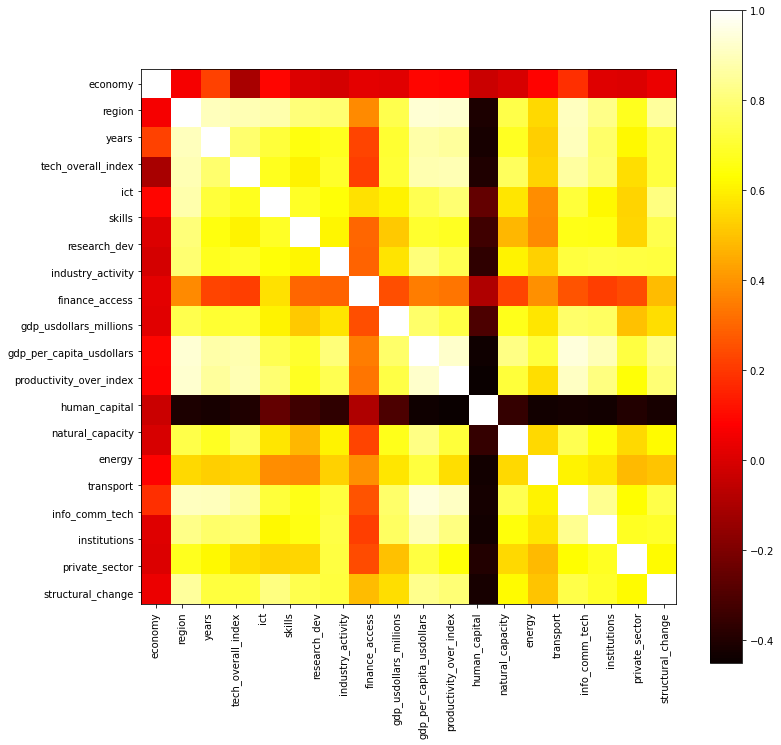

In [8]:
# Correlation Matrix heatmap for df

corr_matrix= summary_gdp.corr()
corr_matrix
fig_cor, axes_cor = plt.subplots(1,1)
fig_cor.set_size_inches(12, 12)

labels = summary_gdp.columns.tolist()

myimage = axes_cor.imshow(corr_matrix, cmap='hot', interpolation='nearest')

plt.colorbar(myimage)

axes_cor.set_xticks(np.arange(0,corr_matrix.shape[0], corr_matrix.shape[0]*1.0/len(labels)))
axes_cor.set_yticks(np.arange(0,corr_matrix.shape[1], corr_matrix.shape[1]*1.0/len(labels)))

axes_cor.set_xticklabels(labels,rotation=90, fontsize=10)
axes_cor.set_yticklabels(labels,fontsize=10)
axes_cor.set_xticklabels(labels)
axes_cor.set_yticklabels(labels)

plt.draw()
corr_matrix

In [9]:
### Multicolinearity model after corr_matrix

### Binary Encoding Categorical Data

In [10]:
# df summary of information to find which features to encode
summary_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   economy                   1705 non-null   object 
 1   region                    1705 non-null   object 
 2   years                     1705 non-null   int64  
 3   tech_overall_index        1705 non-null   float64
 4   ict                       1705 non-null   float64
 5   skills                    1705 non-null   float64
 6   research_dev              1705 non-null   float64
 7   industry_activity         1705 non-null   float64
 8   finance_access            1705 non-null   float64
 9   gdp_usdollars_millions    1705 non-null   float64
 10  gdp_per_capita_usdollars  1705 non-null   float64
 11  productivity_over_index   1705 non-null   float64
 12  human_capital             1705 non-null   float64
 13  natural_capacity          1705 non-null   float64
 14  energy  

In [11]:
# Binary encoding using Pandas (multiple columns)
GDP_binary_encoded = pd.get_dummies(summary_gdp, columns=["economy", "region", "years"])
GDP_binary_encoded.head()

,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,gdp_per_capita_usdollars,productivity_over_index,human_capital,...,years_2009,years_2010,years_2011,years_2012,years_2013,years_2014,years_2015,years_2016,years_2017,years_2018
0,0.072075,0.103354,0.170865,0.000000,0.331855,0.242233,10236.90159,387.362338,18.823282,31.094856,...,0,0,0,0,0,0,0,0,0,0
1,0.071051,0.079601,0.165315,0.000000,0.401368,0.308691,11595.13347,423.407102,19.255622,32.643189,...,1,0,0,0,0,0,0,0,0,0
2,0.096194,0.078095,0.156798,0.000000,0.435488,0.310786,14698.88968,521.428191,19.380531,33.306044,...,0,1,0,0,0,0,0,0,0,0
3,0.123014,0.087214,0.151915,0.000000,0.358647,0.323599,17350.69495,593.203248,19.844802,33.294867,...,0,0,1,0,0,0,0,0,0,0
4,0.052903,0.074048,0.154567,0.055488,0.343089,0.161664,19136.49934,628.116539,20.460732,34.443517,...,0,0,0,1,0,0,0,0,0,0


In [12]:
GDP_binary_encoded.isnull().any()

tech_overall_index    False
ict                   False
skills                False
research_dev          False
industry_activity     False
                      ...  
years_2014            False
years_2015            False
years_2016            False
years_2017            False
years_2018            False
Length: 190, dtype: bool

In [13]:
GDP_binary_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Columns: 190 entries, tech_overall_index to years_2018
dtypes: float64(17), uint8(173)
memory usage: 514.6 KB


In [14]:
integer_columns = GDP_binary_encoded.select_dtypes(include=['int64']).columns
float_columns = GDP_binary_encoded.select_dtypes(include=['float64']).columns
uint8_columns = GDP_binary_encoded.select_dtypes(include=['uint8']).columns

In [15]:
print('\nint64 columns:\n', integer_columns)
print('\nfloat64 columns:\n', float_columns)
print('\nuint8 columns:\n', uint8_columns)


int64 columns:
 Index([], dtype='object')

float64 columns:
 Index(['tech_overall_index', 'ict', 'skills', 'research_dev',
       'industry_activity', 'finance_access', 'gdp_usdollars_millions',
       'gdp_per_capita_usdollars', 'productivity_over_index', 'human_capital',
       'natural_capacity', 'energy', 'transport', 'info_comm_tech',
       'institutions', 'private_sector', 'structural_change'],
      dtype='object')

uint8 columns:
 Index(['economy_Afghanistan', 'economy_Albania', 'economy_Algeria',
       'economy_Argentina', 'economy_Armenia', 'economy_Australia',
       'economy_Austria', 'economy_Azerbaijan', 'economy_Bahamas',
       'economy_Bahrain',
       ...
       'years_2009', 'years_2010', 'years_2011', 'years_2012', 'years_2013',
       'years_2014', 'years_2015', 'years_2016', 'years_2017', 'years_2018'],
      dtype='object', length=173)


In [16]:
# Drop int64 

GDP_binary = GDP_binary_encoded.select_dtypes(exclude=['int64'])
GDP_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Columns: 190 entries, tech_overall_index to years_2018
dtypes: float64(17), uint8(173)
memory usage: 514.6 KB


### Setting X and y values

In [17]:
X=GDP_binary_encoded.drop(['gdp_usdollars_millions'],axis=1)
y=GDP_binary_encoded['gdp_usdollars_millions']

### Standardized Data

#### Chose to standardize data as large economies will come up as outliers

In [18]:
# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
data_scaler = StandardScaler()

In [19]:
# Fitting the scaler
GDP_data_scaled = data_scaler.fit_transform(GDP_binary_encoded)
GDP_data_scaled[:5]

array([[-1.26019217, -1.0630201 , -1.26595101, -1.00377256, -0.7525023 ,
        -1.73168136, -0.26954716, -0.7155719 , -1.73769848, -1.46547272,
         0.74710157, -0.7341518 , -1.22861578, -1.27085087, -1.96913581,
        -2.67115942, -0.93993417, 12.40967365, -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 , -0.0805823 ,
        -0.0805823 , -0.0805823 , -0.0805823 , -0.0

In [20]:
# Verifying the mean and standard deviation
print(np.mean(GDP_data_scaled[:,0]))
print(np.std(GDP_data_scaled[:,0]))

2.0837030374196488e-16
0.9999999999999999


## Model #1: Multivariate Linear Regression

### Multivariate Regression on all fifteen features for X and gdp_usdollars_millions for y.

### Splitting test and training data and placing in model

In [21]:
# Use train_test_split to create training and testing data.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
# Create the model by using LinearRegression.
from sklearn.linear_model import LinearRegression
model = LinearRegression()

### Fitting model

In [23]:
# Fit the model to the training data, and calculate the scores for the training and testing data.
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### Test and Training Score Results

In [24]:
# Predict the test set results
y_pred=model.predict(X_test)
print(y_pred)

[-2.18849581e+04  6.02325211e+05  2.09956335e+06  1.43556352e+05
  9.41015377e+04  1.19540267e+05 -3.90935788e+04 -1.85206166e+05
 -4.42328572e+04  5.74314263e+04  5.02192320e+04  2.74745936e+06
  1.44166174e+05 -6.68869846e+04  6.66603656e+04  1.86402768e+04
  7.60348358e+04  5.22962641e+06  4.76660755e+04  8.76493767e+04
 -2.24090488e+05 -9.25315106e+04  5.16802887e+04  2.57379664e+05
  1.86792591e+05  1.86169222e+05 -1.08695439e+05  3.29595058e+05
  1.02328912e+03  4.17608912e+05  7.52487509e+04  1.37520669e+06
  9.73545966e+04  5.98970026e+04 -3.16568844e+04  1.11681299e+05
 -1.14967244e+05  1.49314657e+06  1.17347595e+05  1.08140536e+05
 -3.61013320e+05  5.35902716e+05  1.42069060e+04 -2.92915422e+04
 -3.23242391e+04  1.38720108e+05 -6.32415263e+04  1.63237862e+06
  3.85353576e+05 -2.85716022e+05 -4.95029266e+04  1.15512041e+05
  2.18025119e+06  2.30256064e+05  4.28012982e+04  3.52672120e+04
 -3.11446874e+05 -6.82684795e+03  2.29184872e+05  2.19767773e+05
  1.57296288e+03  7.42965

In [25]:
# r2_score for both Test and Training data

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.9713832416765708
Testing Score: 0.9833686396176141


Text(0.5, 1.0, 'Actual vs. Predicted')

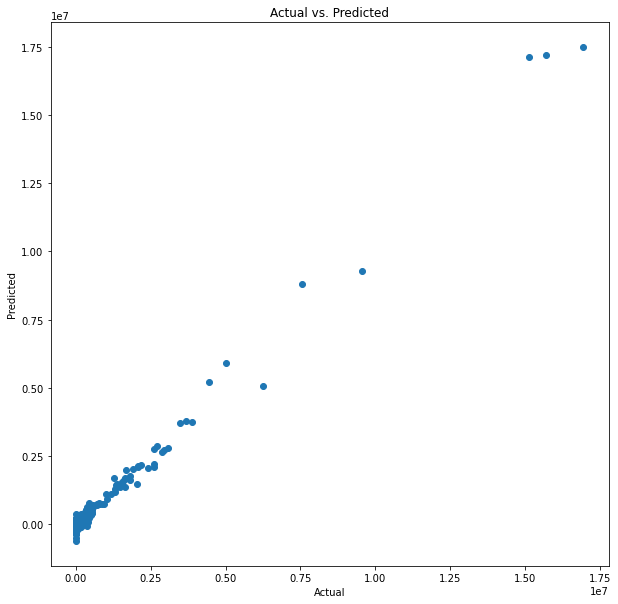

In [26]:
# Plotting Actual vs Predicted test values

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

,Actual Value,Predicted value,Difference
1046,6.528290e+03,-2.188496e+04,28413.248190
745,4.660831e+05,6.023252e+05,-136242.093399
785,2.087077e+06,2.099563e+06,-12486.320815
367,1.769392e+04,1.435564e+05,-125862.428970
1029,1.280344e+04,9.410154e+04,-81298.098713
...,...,...,...
1568,2.764253e+04,4.603710e+04,-18394.577047
358,1.148058e+03,-7.471427e+04,75862.330025
901,3.442902e+04,9.067273e+04,-56243.709855
236,5.581139e+04,8.206632e+04,-26254.935131


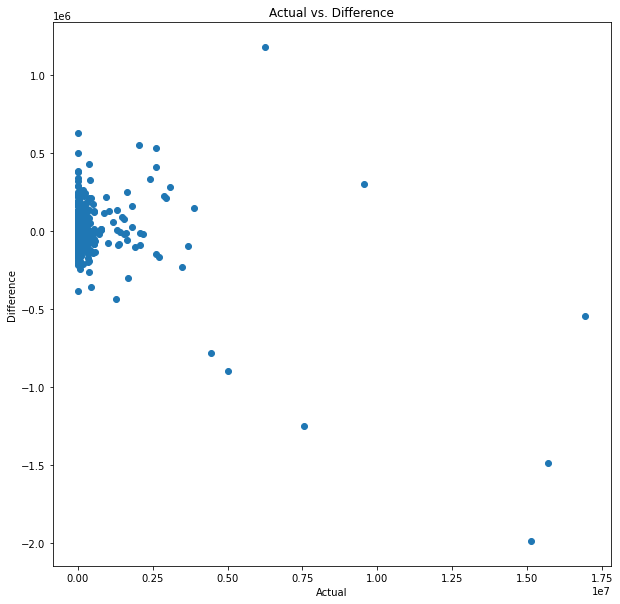

In [27]:
# Plotting Actual Value vs Difference in Actual and Predicted Values

pred_y_df=pd.DataFrame({'Actual Value':y_test, 'Predicted value':y_pred, 'Difference': y_test-y_pred})

plt.rcParams["figure.figsize"] = (10,10)
plt.scatter(y_test,(y_test-y_pred))
plt.xlabel('Actual')
plt.ylabel('Difference')
plt.title('Actual vs. Difference')
pred_y_df

## Model #2: Random Forest

In [28]:
# Removing economy, region, years due to too many columns for model
#summary_gdp = summary_gdp_df.drop(['country_code','coft_id'], axis=1)
rf_gdp = summary_gdp_df.drop(['country_code','coft_id', 'economy', 'region', 'years'], axis=1)

In [29]:
rf_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1705 entries, 0 to 1704
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tech_overall_index        1705 non-null   float64
 1   ict                       1705 non-null   float64
 2   skills                    1705 non-null   float64
 3   research_dev              1705 non-null   float64
 4   industry_activity         1705 non-null   float64
 5   finance_access            1705 non-null   float64
 6   gdp_usdollars_millions    1705 non-null   float64
 7   gdp_per_capita_usdollars  1705 non-null   float64
 8   productivity_over_index   1705 non-null   float64
 9   human_capital             1705 non-null   float64
 10  natural_capacity          1705 non-null   float64
 11  energy                    1705 non-null   float64
 12  transport                 1705 non-null   float64
 13  info_comm_tech            1705 non-null   float64
 14  institut

In [30]:
rf_gdp.isnull().any()

tech_overall_index          False
ict                         False
skills                      False
research_dev                False
industry_activity           False
finance_access              False
gdp_usdollars_millions      False
gdp_per_capita_usdollars    False
productivity_over_index     False
human_capital               False
natural_capacity            False
energy                      False
transport                   False
info_comm_tech              False
institutions                False
private_sector              False
structural_change           False
dtype: bool

In [31]:
df = rf_gdp

# Drop as these had null values
#df.drop(['economy', 'region'], axis=1, inplace=True)
#df.dropna(inplace=True)

#X=GDP_binary_enco.drop(['gdp_usdollars_millions'],axis=1)
#y=GDP_binary_encoded['gdp_usdollars_millions']
        
X = df.drop(["gdp_usdollars_millions"], axis=1)
y = df["gdp_usdollars_millions"] != 1

In [32]:
df.head()

,tech_overall_index,ict,skills,research_dev,industry_activity,finance_access,gdp_usdollars_millions,gdp_per_capita_usdollars,productivity_over_index,human_capital,natural_capacity,energy,transport,info_comm_tech,institutions,private_sector,structural_change
0,0.072075,0.103354,0.170865,0.000000,0.331855,0.242233,10236.90159,387.362338,18.823282,31.094856,58.485536,22.258151,8.488684,3.577535,15.947558,54.600186,14.723942
1,0.071051,0.079601,0.165315,0.000000,0.401368,0.308691,11595.13347,423.407102,19.255622,32.643189,58.328269,23.138830,8.760733,3.879257,15.463749,53.510755,15.254662
2,0.096194,0.078095,0.156798,0.000000,0.435488,0.310786,14698.88968,521.428191,19.380531,33.306044,58.486524,23.272956,8.972955,3.836936,16.084957,51.441468,15.411381
3,0.123014,0.087214,0.151915,0.000000,0.358647,0.323599,17350.69495,593.203248,19.844802,33.294867,58.243822,24.590893,8.958996,4.160740,16.593136,51.107480,15.956214
4,0.052903,0.074048,0.154567,0.055488,0.343089,0.161664,19136.49934,628.116539,20.460732,34.443517,58.087595,24.901164,8.905547,4.308839,20.446555,51.082891,15.383048


In [33]:
# Train and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
X_train_scaled

array([[-0.47961456, -0.90556063,  0.14344899, ..., -0.06928215,
        -2.50480643, -0.49485894],
       [-0.1469909 ,  0.34059551,  0.07084979, ...,  0.28632302,
         0.54220629, -0.08436405],
       [ 1.25684417,  0.6668665 ,  1.1679283 , ...,  1.58301452,
         1.5385205 ,  1.16250175],
       ...,
       [-1.14586105, -1.10878531, -1.51990943, ..., -0.70206384,
        -0.19864492, -0.93263824],
       [ 0.66303113,  1.13155557,  0.59868329, ...,  0.19410892,
         0.19273728,  0.75956171],
       [-0.47129204, -0.68217069,  0.34405999, ..., -0.24905083,
        -0.93591245, -0.59751092]])

In [35]:
clf = RandomForestClassifier(random_state=1, n_estimators=1000).fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

Training Score: 1.0
Testing Score: 1.0


In [36]:
feature_importances = clf.feature_importances_

In [37]:

#print(sorted(zip(clf.feature_importances, X.columns), reverse=True))


AttributeError: 'RandomForestClassifier' object has no attribute 'feature_importances'

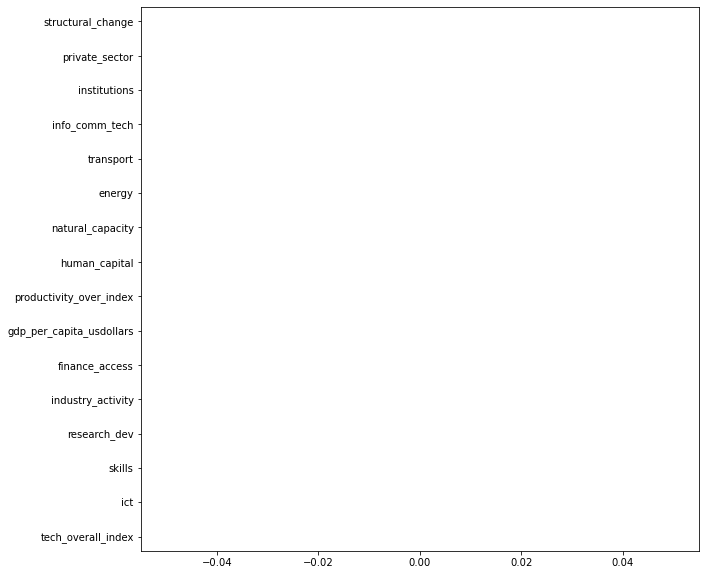

In [38]:
features = sorted(zip(X.columns, clf.feature_importances_), key = lambda x: x[1])
cols = [f[0] for f in features]
width = [f[1] for f in features]

fig, ax = plt.subplots()

fig.set_size_inches(10,10)
plt.margins(y=0.001)

ax.barh(y=cols, width=width)

plt.show()

In [39]:
from sklearn.feature_selection import SelectFromModel
sel = SelectFromModel(clf)
sel.fit(X_train_scaled, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000,
                                                 random_state=1))

In [40]:
X_selected_train, X_selected_test, y_train, y_test = train_test_split(sel.transform(X), y, random_state=1)
scaler = StandardScaler().fit(X_selected_train)
X_selected_train_scaled = scaler.transform(X_selected_train)
X_selected_test_scaled = scaler.transform(X_selected_test)

C:\Users\ralph\Anaconda\envs\mlenv\lib\site-packages\sklearn\base.py:435: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [41]:
clf = LogisticRegression().fit(X_train_scaled, y_train)
print(f'Training Score: {clf.score(X_train_scaled, y_train)}')
print(f'Testing Score: {clf.score(X_test_scaled, y_test)}')

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: True